# Use k-means clustering to find neighborhoods

This notebook should be run after cell phenotype labels have been generated. This notebook walks through generation of neighborhoods using k-means clustering.

Part 1 walks through steps for pre-processing the data, including reading the single cell data and counting the number of neighbors for each cell within a specified pixel radius. Part 2 walks through calculating two metrics that can be used to help determine the optimal number of neighborhoods, k. Part 3 uses k-means clustering to find the neighborhoods. Part 4 walks through some visualizations and Part 5 saves the data.

In [ ]:
import os

import pandas as pd
from alpineer import io_utils, load_utils, misc_utils
from scipy.stats import zscore

import ark.settings as settings
from ark.analysis import (neighborhood_analysis, spatial_analysis_utils,
                          visualize)
from ark.utils import data_utils, example_dataset, plot_utils

## 0. Download the Example Dataset

Here we are using the example data located in `/data/example_dataset/input_data`. To modify this notebook to run using your own data, simply change the `base_dir` to point to your own sub-directory within the data folder, rather than `'example_dataset'`.

* `base_dir`: the path to all of your imaging data. This directory will contain all of the data generated by this notebook.

In [ ]:
base_dir = "../data/example_dataset"

If you would like to test the features in Ark with an example dataset, run the cell below. It will download a dataset consisting of 11 FOVs with 22 channels. You may find more information about the example dataset in the [README](../README.md#example-dataset).

* `overwrite_existing`: If set to `False`, it will not overwrite existing data in the `data/example_dataset`. Recommended setting it to `True` if you have not run Notebooks 1-3.

In [ ]:
example_dataset.get_example_dataset(dataset="neighborhood_analysis", save_dir=base_dir, overwrite_existing=False)

## 1. Pre-process data

Check `settings.py` and confirm that the correct column names are specified. Importantly, the cell phenotype labels generated from cell clustering should be specified by the "CELL_TYPE" variable in `settings.py`. The k-means cluster IDs will be written to the "KMEANS_CLUSTER" column specified in `settings.py`.

* `base_dir`: the path to all of your imaging data. Should contain a directory for your images, segmentations, and cell table (generated from `1_Segment_Image_Data.ipynb`). This directory will also store all of the directories/files created during neighborhood analysis.
* `segmentation_dir`: the path to the directory containing your segmentations (generated from `1_Segment_Image_Data.ipynb`).
* `cell_table_path`: the path to the cell table that contains columns for fov, cell label, and cell phenotype (generated from `3_Pixie_Cluster_Cells.ipynb`)
* `spatial_analysis_dir`: the path to the output directory to store all files created during neighborhood analysis

### 1.1 Read data

In [ ]:
segmentation_dir = os.path.join(base_dir, "segmentation/deepcell_output")
cell_table_path = os.path.join(base_dir, "segmentation/cell_table/cell_table_size_normalized_cell_labels.csv")
spatial_analysis_dir = os.path.join(base_dir, "spatial_analysis/neighborhood_analysis")

neighbors_mat_dir = os.path.join(base_dir, "spatial_analysis/neighborhood_mats")
dist_mat_dir = os.path.join(base_dir, "spatial_analysis/dist_mats")

# Create output directory
if not os.path.exists(spatial_analysis_dir):
    os.makedirs(spatial_analysis_dir)
if not os.path.exists(neighbors_mat_dir):
    os.makedirs(neighbors_mat_dir)

In [ ]:
# Validate file paths
io_utils.validate_paths([
    base_dir,
    segmentation_dir,
    cell_table_path,
    spatial_analysis_dir
])

In [ ]:
# Read cell table, only fovs in the cell table will be included in the analysis
all_data = pd.read_csv(cell_table_path)
all_fovs = all_data[settings.FOV_ID].unique()

In [ ]:
# create the dist_mat_output directory if it doesn't exist
if not os.path.exists(dist_mat_dir):
    os.makedirs(dist_mat_dir)
    spatial_analysis_utils.calc_dist_matrix(all_data, dist_mat_dir, fov_id='fov', label_id='label', 
                                            centroid_ids=('centroid-0', 'centroid-1'))  
    
# verify all the FOVs computed exist in all_data
misc_utils.verify_in_list(
    dist_mat_fovs=[f.replace('_dist_mat.xr', '') for f in io_utils.list_files(dist_mat_dir, substrs='_dist_mat.xr')],
    input_fovs=all_data[settings.FOV_ID].unique()
)

### 1.2 Find neighbors for each cell

We will now define the neighbors matrix, which will be used as our input for clustering. For each cell in the cell table, count the number of each cell phenotype within a certain distance of that cell. If a cell has no other cells within the distance specfied by `pixel_radius`, that cell is excluded from the analysis.

The neighbors matrix is saved in the `neighbors_mat_dir`.
- `pixel_radius`: radius used to define the neighbors of each cell
- `cell_type_col`: name of the column in your cell table containing cell phenotypes

In [ ]:
pixel_radius = 50
cell_type_col = settings.CELL_TYPE

counts_path = os.path.join(neighbors_mat_dir, f"neighborhood_counts-{cell_type_col}_radius{pixel_radius}.csv")
freqs_path = os.path.join(neighbors_mat_dir, f"neighborhood_freqs-{cell_type_col}_radius{pixel_radius}.csv")

**If you have previously generated a neighbors matrix with the `pixel_radius` and `cell_type_col` specified, the data will be loaded in below. Otherwise, a new neighbors matrix will be created.**

In [ ]:
# Check for existing neighbors matrix
if os.path.exists(counts_path) and os.path.exists(freqs_path):
    neighbor_counts = pd.read_csv(counts_path)
    neighbor_freqs = pd.read_csv(freqs_path) 
    
else:
    # Create new matrix with the radius and cell column specified above
    neighbor_counts, neighbor_freqs = neighborhood_analysis.create_neighborhood_matrix(
        all_data, dist_mat_dir, distlim=pixel_radius, cell_type_col=cell_type_col)
    
    # Save neighbor matrices
    neighbor_counts.to_csv(counts_path, index=False)
    neighbor_freqs.to_csv(freqs_path, index=False)

Choose whether to find neighborhoods using count (number of each cell phenotype) or frequency (number of each cell phenotype divided by total number of close neighbors for each cell).

In [ ]:
# This variable can be "counts" or "frequency"
neighborhood_method = "counts"

if neighborhood_method == "counts":
    input_features = neighbor_counts
elif neighborhood_method == "frequency":
    input_features = neighbor_freqs
else:
    raise ValueError("neighborhood_method must be either 'counts' or 'frequency'")

## 2. Find optimal k using various metrics

Use various metrics to determine the optimal k for k-means clustering. k's ranging from `min_k` to `max_k` will be tested.

In [ ]:
# The minimum and maximum k that will be tested
min_k = 2
max_k = 10

### 2.1 Inertia

Inertia is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster.

  0%|          | 0/9 [00:00<?]

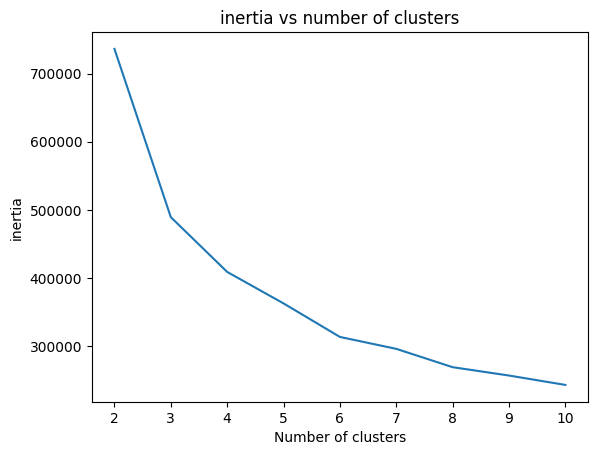

In [ ]:
neighbor_inertia = neighborhood_analysis.compute_cluster_metrics_inertia(input_features, min_k=min_k, max_k=max_k, 
                                                                         cell_col=cell_type_col)

# Use the elbow curve method to choose the optimal k
visualize.visualize_neighbor_cluster_metrics(neighbor_inertia, metric_name="inertia")

### 2.2 Silhouette score

The Silhouette score is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette score for a sample is `(b - a) / max(a, b)`.

Silhouette score can be an expensive calculation, so depending on the size of your dataset, you may want to subsample the number of cells in each cluster for this calculation. Each neighborhoood cluster will be sampled down to the number of cells specified by `num_cells_per_cluster`. Set this variable as `None` to use all cells.

  0%|          | 0/9 [00:00<?]

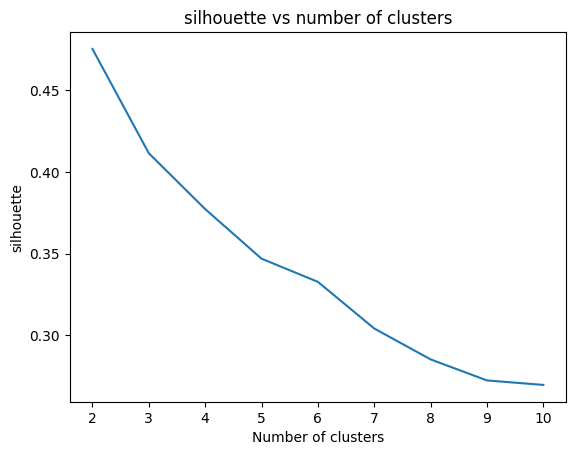

In [ ]:
# Subsample each phenotype to avoid long runtimes
num_cells_per_cluster = 1000

neighbor_silhouette_scores = neighborhood_analysis.compute_cluster_metrics_silhouette(input_features,
                                                                                      min_k=min_k, max_k=max_k,
                                                                                      subsample=num_cells_per_cluster, 
                                                                                      cell_col=cell_type_col)

# Use the elbow curve method to choose the optimal k
visualize.visualize_neighbor_cluster_metrics(neighbor_silhouette_scores, metric_name="silhouette")

## 3. Generate cluster results

While the metrics above algorithmically help to choose a k, visualizing the clustering results may help choose the best k. Iterate between steps 3 and 4 to choose the optimal cluster number.

In [ ]:
# Set k value here based on results from graphs above and visualization results
k = 6

In [ ]:
# These channels will be excluded when generating table of mean marker expression per neighborhood cluster
excluded_channels = None

# k-means clustering
all_data_cluster_labeled, num_cell_type_per_cluster, mean_marker_exp_per_cluster = \
    neighborhood_analysis.generate_cluster_matrix_results(
        all_data, input_features, cluster_num=k, excluded_channels=excluded_channels, cell_type_col=cell_type_col)

## 4. Visualize cluster results

### 4.1 Cluster composition by neighboring cell types
First, we want to understand how the generated clusters relate to the input data that was provided (neighboring cell types by either count or frequency). Below, we find the average count/frequency of neighboring cell phenotypes that surround the cells belonging to each cluster (then z-score those values within each cell type).

In [ ]:
# Directory to save kmeans output for the specified parameters
kmeans_out_dir = os.path.join(spatial_analysis_dir, f"{cell_type_col}_radius{pixel_radius}_{neighborhood_method}")
if not os.path.exists(kmeans_out_dir):
    os.makedirs(kmeans_out_dir)

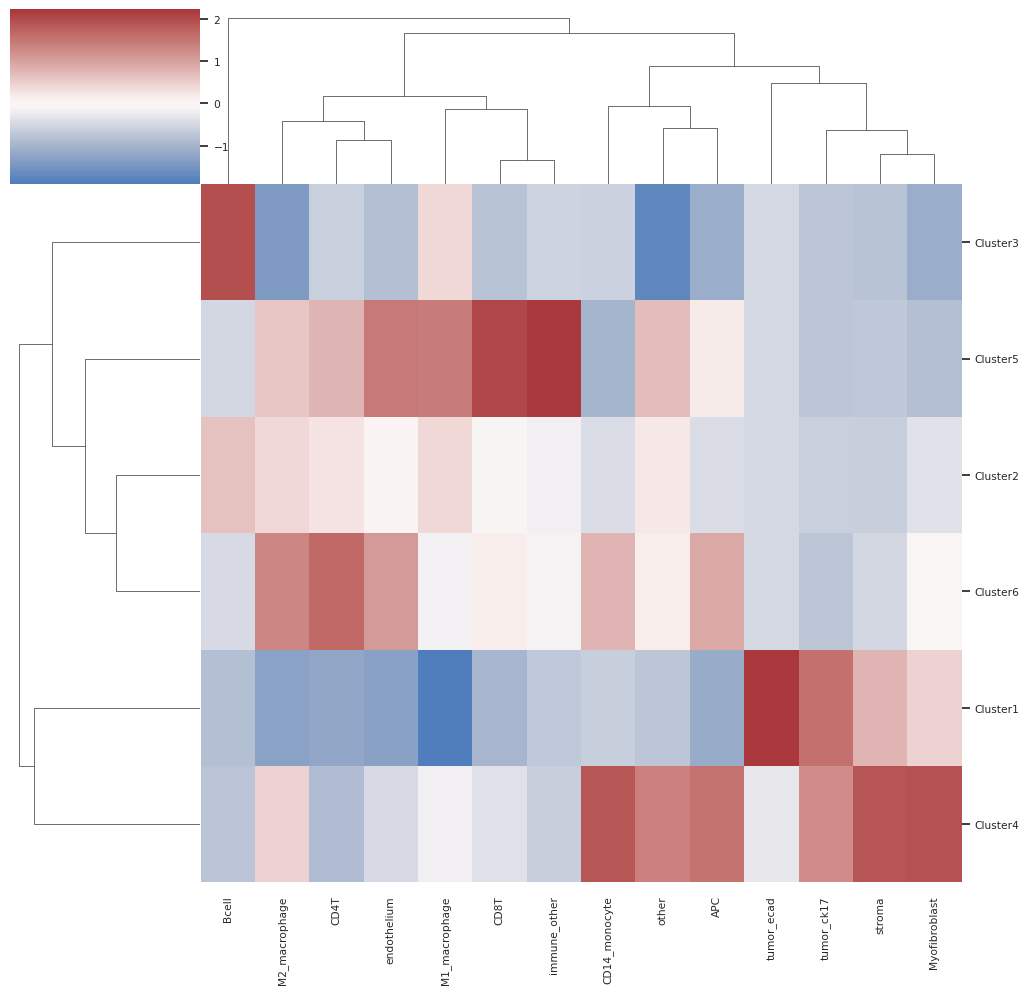

In [ ]:
# Combine composition data with neighborhood labels
merged_dat = input_features.merge(all_data_cluster_labeled[[settings.FOV_ID, settings.CELL_LABEL, settings.KMEANS_CLUSTER]],
                                  on=[settings.FOV_ID, settings.CELL_LABEL])
# Get mean composition of cells in each neighborhood
merged_dat = merged_dat.drop([settings.FOV_ID, settings.CELL_LABEL], axis=1)
mean_dat = merged_dat.groupby(settings.KMEANS_CLUSTER, as_index=False).mean(numeric_only=True)

# Draw heatmap
mean_dat_values = mean_dat.drop(settings.KMEANS_CLUSTER, axis=1)
visualize.draw_heatmap(data=mean_dat_values.apply(zscore).values,
                       x_labels=["Cluster"+str(x) for x in mean_dat[settings.KMEANS_CLUSTER].values],
                       y_labels=mean_dat.drop(settings.KMEANS_CLUSTER, axis=1).columns.values,
                       center_val=0, save_dir=kmeans_out_dir, save_file='neighbor_type_heatmap')

### 4.2 Cluster composition by cell phenotype
Now we want to examine the number of each cell type assigned to each kmeans neighborhood cluster (z-scored for each cell type).

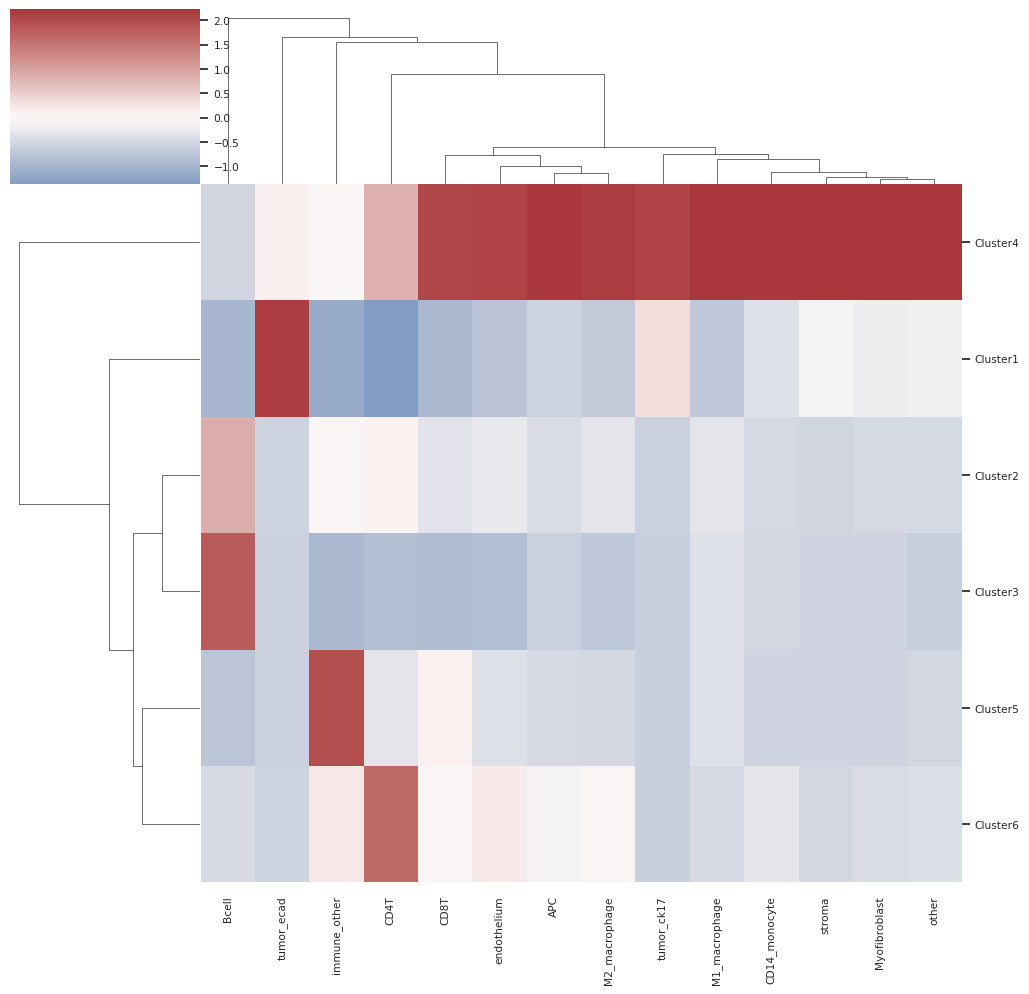

In [ ]:
visualize.draw_heatmap(data=num_cell_type_per_cluster.apply(zscore).values,
                       x_labels=num_cell_type_per_cluster.index.values,
                       y_labels=num_cell_type_per_cluster.columns.values,
                       center_val=0, save_dir=kmeans_out_dir, save_file='cell_type_heatmap')

### 4.3 Cluster composition by mean marker expression
Finally, we want to examine the average marker expression of the cells assigned to each kmeans neighborhood cluster (z-scored for each marker).

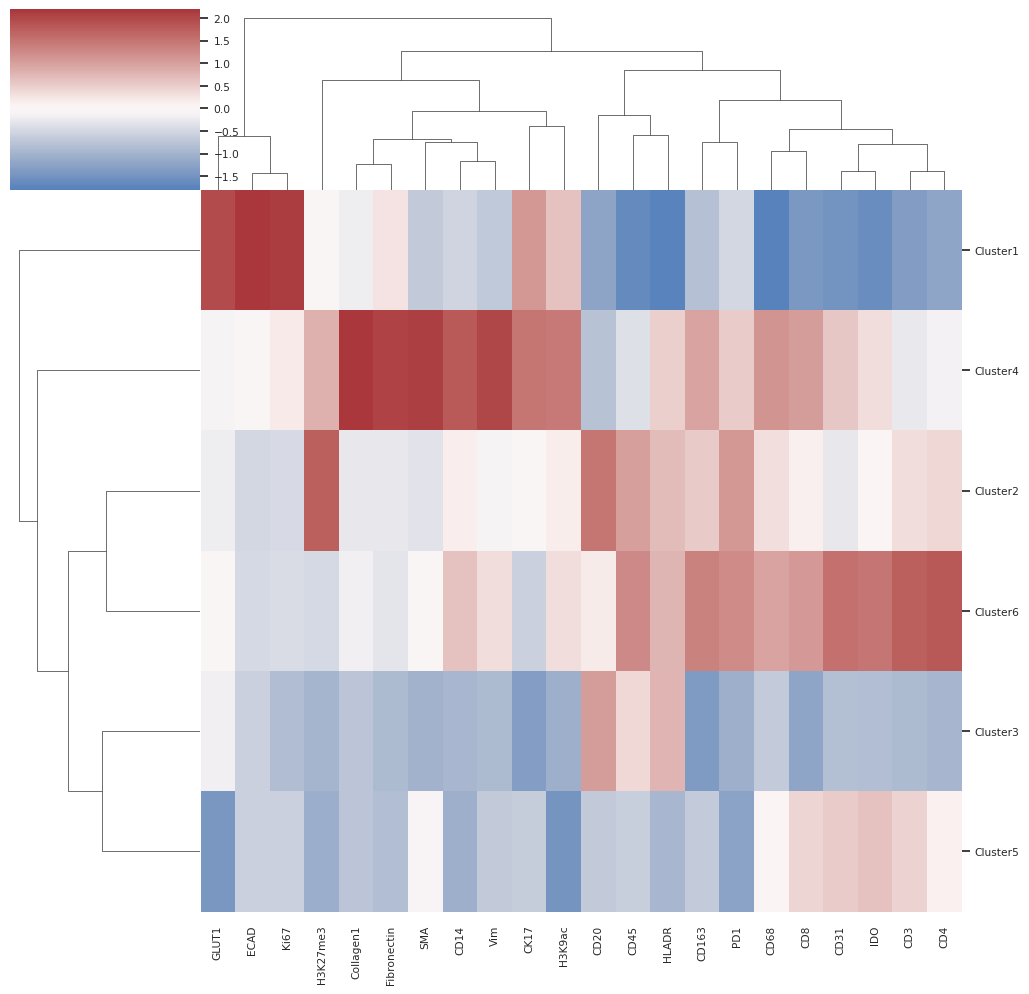

In [ ]:
visualize.draw_heatmap(data=mean_marker_exp_per_cluster.apply(zscore).values,
                       x_labels=mean_marker_exp_per_cluster.index.values,
                       y_labels=mean_marker_exp_per_cluster.columns.values,
                       center_val=0, save_dir=kmeans_out_dir, save_file='marker_expression_heatmap')

### 4.4 Overlay segmentation with neighborhood clusters

It may be helpful to view a few example overlays to assess clustering. For example, for a dataset of lymph nodes, we would expect to see neighborhoods corresponding to the T cell zone, B cell zone, germinal centers, etc.

In [ ]:
# Directory to save overlays
overlay_out_dir = os.path.join(kmeans_out_dir, "overlays")
if not os.path.exists(overlay_out_dir):
    os.makedirs(overlay_out_dir)

In [ ]:
# select fovs to display
subset_neighborhood_fovs = ['fov6']

# generate and save the neighborhood masks for the fovs to display
data_utils.generate_and_save_neighborhood_cluster_masks(
    fovs=subset_neighborhood_fovs,
    save_dir=overlay_out_dir,
    seg_dir=segmentation_dir,
    neighborhood_data=all_data_cluster_labeled,
    name_suffix='_neighborhood_mask'
)

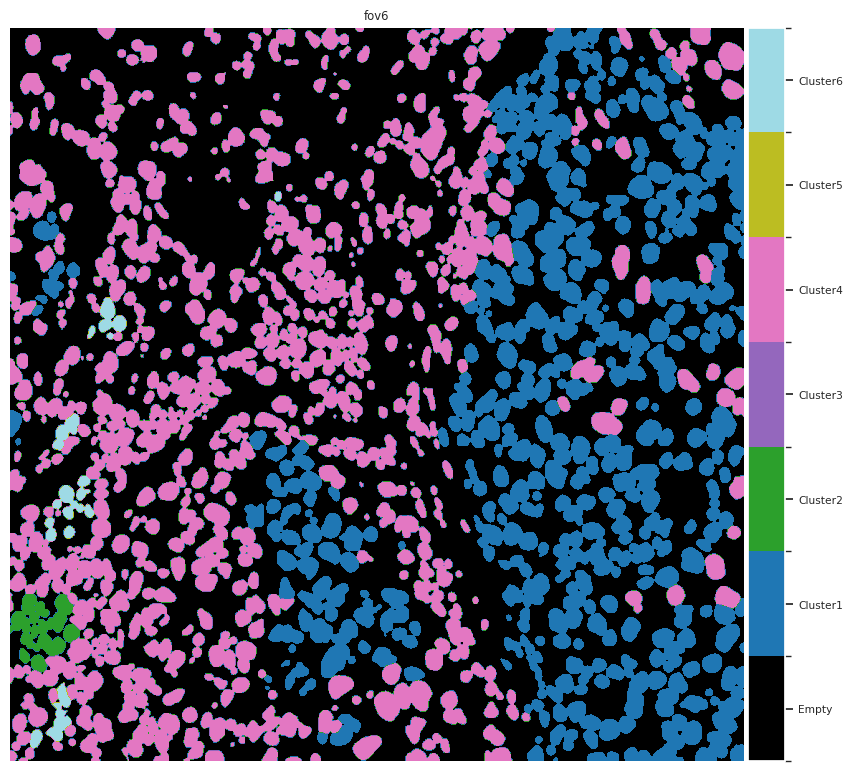

In [ ]:
# load the masks in and plot them
for fov in subset_neighborhood_fovs:
    neighborhood_mask = load_utils.load_imgs_from_dir(
        data_dir=overlay_out_dir,
        files=[fov + "_neighborhood_mask.tiff"],
        trim_suffix="_neighborhood_mask",
        match_substring="_neighborhood_mask",
        xr_dim_name="neighborhood_mask",
        xr_channel_names=None,
    )

    plot_utils.plot_neighborhood_cluster_result(
        img_xr=neighborhood_mask,
        fovs=[fov],
        k=k,
        cmap_name="tab20",
        cbar_visible=True,
        save_dir=None,
    )

## 5. Save data

### 5.1 Save data

After running k-means using the optimal k, re-save the cell table with neighborhood cluster ID appended. All cells from the original table are contained within the new one, even if they had no neighbors and were excluded from k-means clustering. 

In [ ]:
#  Save cell table
new_table_name = os.path.basename(cell_table_path).replace(".csv", "_kmeans_nh.csv")
new_table_path = os.path.join(kmeans_out_dir, new_table_name)
cell_table_new = all_data.merge(all_data_cluster_labeled, on=list(all_data.columns), how='left')
cell_table_new.to_csv(new_table_path, index=False)

# Save number of each cell type and mean marker expression per neighborhood
num_cell_type_per_cluster.to_csv(os.path.join(kmeans_out_dir, "neighborhood_cell_type.csv"), index=True, index_label=settings.KMEANS_CLUSTER)
mean_marker_exp_per_cluster.to_csv(os.path.join(kmeans_out_dir, "neighborhood_marker.csv"), index=True, index_label=settings.KMEANS_CLUSTER)

### 5.2 Save overlay for all FOVs

In [ ]:
# generate and save the neighborhood masks for all the fovs
data_utils.generate_and_save_neighborhood_cluster_masks(
    fovs=all_fovs,
    save_dir=overlay_out_dir,
    seg_dir=segmentation_dir,
    neighborhood_data=all_data_cluster_labeled,
    name_suffix='_neighborhood_mask'
)